0.25979478895093644



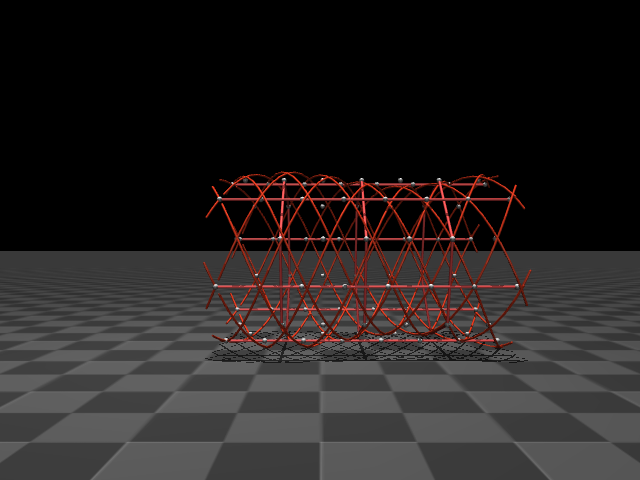

In [1]:
## SNS controller for peristaltic locomotion of a 3D simulated worm robot
#
# Author: Shane Riddle
#
# Last edited: 04/02/2023
#########################################################################

# The worm robot is simulated in Mujoco using composite cable objects for 
# the structure, circumferential muscles for the actuators, and tendons 
# for the springs. The model can be altered in the xml file. Note that 
# alterations to the xml file will likely require alterations to the rest 
# of this code.

# The muscle activation signal is related to the CPG neuron potentials
# via a sigmoid mapping. The muscle tension forces are determined using 
# a force-length-velocity curve. The tendon spring lengths aqcuired from 
# Mujoco are used as stretch sensor feedback for the SNS control network.

########################### Import packages #############################

# SNS-Toolbox and Mujoco Packages
from sns_toolbox.neurons import NonSpikingNeuron, NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.networks import Network
from sns_toolbox.renderer import render
import mujoco

# Basic Utility and Plotting Packages
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# Movie Making Packages  (Use mediapy for Mujoco)
import matplotlib.animation as animation
import mediapy as media


########################### Define functions ############################

## m and h steady state and time constant functions (z is a placeholder)
# Steady-state value of z, as a function of U.
def zInf(U, Kz, Sz, Ez):
    return 1/(1+Kz*np.exp(Sz*(Ez-U)))

# Time constant of z, as a function of U.
def tauz(U, tauzmax, Kz, Sz, Ez):
    return tauzmax*zInf(U, Kz, Sz, Ez)*np.sqrt(Kz*np.exp(Sz*(Ez-U)))

## Synaptic conductance function
def g(U, gsyn, R):
    return np.minimum(np.maximum(U/R, 0), 1)*gsyn

# sigmoidal activation for muscles
def sns2mujoco(input, sig_slope, center_pt):
    output = 1.0/(1+np.exp(sig_slope*(input-center_pt)))
    return output



######################### Network Parameters ############################

## Neuron and synapse properties (Units are nF, uS, mV, ms, nA)
C = 5
Gm = 1
tauHmax = 300       # 300 is default (200 and 100 also used for faster action)
Er = -60            # resting potential, biologically typical value
delta = .01         # bifurcation thingy
R = 20
offset = 0.1        # R offset for CPG stopped states
Nseg = 3            # 6, number of segments

# Speed gain for controller (if using instead of max/min Speed)
k = 1.3             # 1.3 is min value when tauHmax is 300 (1.9 for 200, 3.6 for 100)

# Stability Notes: Period for tauHmax=300 and k=1.3 is 5250ms (measured by sensor signal). Already "stable" after the first cycle.

# makes sense biologically that excitatory delE higher than inhibitory
# Inhibitory Synapse Porperties (???? transmitter)
Einh = -100
delEsyn = Einh - Er

# Excitatory Synapse Properties (calcium transmitter)
Eex = 134
delEsyn_ex = Eex-Er

# Persistent sodium (NaP) channel
Ena = 50
S = .05                 # Slope of the sigmoid of hInf, mInf.
Kh = 0.5
Eh = 0
Km = 1
Em = R
delEna = Ena - Er

# Solve for the conductance of the NaP channel to get U* = R, with no external current or synaptic inputs.
Gna = Gm*R/(zInf(R, Km, S, Em)*zInf(R, Kh, -S, Eh)*(delEna - R))

# Now we know that U* = R, and we can find h* and m* based on that.
Ustar = R
mStar = zInf(Ustar, Km, S, Em)
hStar = zInf(Ustar, Kh, -S, Eh)



############################## SNS Setup ################################

## Set up synapse parameters
# CPG synapses
Esyn1_2 = Einh
delEsyn1_2 = Esyn1_2-Er
gSyn_cpg = (-delta - delta*Gna*zInf(delta, Km, S, Em)*zInf(delta, Kh, -S, Eh) + Gna*zInf(delta, Km, S, Em)*zInf(delta, Kh, -S, Eh)*delEna)/(delta - delEsyn)
gSyn1_2 = gSyn_cpg

# Excitation synapses
# 3-2
Esyn32 = Eex
delEsyn32 = Esyn32-Er
gSyn32 = ((delEsyn1_2*gSyn1_2*(-offset))/((offset+R)*R)-1-gSyn1_2*(-offset)/R)/(1-delEsyn32/(R+offset))
# 2-4
Esyn24 = Eex
delEsyn24 = Esyn24-Er
gSyn24 = R/((delEsyn24/R-1)*(R+offset))

# Inhibition synapses
# 3-1
Esyn31 = Einh
delEsyn31 = Esyn31-Er
gSyn31 = ((delEsyn1_2*gSyn1_2*(R+offset))/(-offset*R)-1-gSyn1_2*(R+offset)/R)/(1+delEsyn31/(-offset))
# 3-4
Esyn34 = Einh
delEsyn34 = Esyn34-Er
gSyn34 = (-delEsyn24*gSyn24*(R+offset))/(delEsyn34*R)
# 4-3
Esyn43 = Einh
delEsyn43 = Esyn43-Er
gSyn43 = -R/delEsyn43


# Define neuron and synapse types
neuron = NonSpikingNeuron(membrane_capacitance = C, membrane_conductance = Gm)
cpg_neuron = NonSpikingNeuronWithPersistentSodiumChannel(membrane_capacitance = C, membrane_conductance = Gm,
                                                         g_ion = [Gna], e_ion = [delEna],
                                                         k_m = [Km], slope_m = [S], e_m = [Em],
                                                         k_h = [Kh], slope_h = [-S], e_h = [Eh], tau_max_h = [tauHmax])

synapse_32 = NonSpikingSynapse(max_conductance = gSyn32, reversal_potential = delEsyn32)
synapse_24 = NonSpikingSynapse(max_conductance = gSyn24, reversal_potential = delEsyn24)
synapse_31 = NonSpikingSynapse(max_conductance = gSyn31, reversal_potential = delEsyn31)
synapse_34 = NonSpikingSynapse(max_conductance = gSyn34, reversal_potential = delEsyn34)
synapse_43 = NonSpikingSynapse(max_conductance = gSyn43, reversal_potential = delEsyn43)
cpg_synapse = NonSpikingSynapse(max_conductance = gSyn1_2, reversal_potential = delEsyn1_2)


## Build SNS network
net = Network()
U1 = 'U1_'
U2 = 'U2_'
U3 = 'U3_'
U4 = 'U4_'
# if statements initialize neuron voltages for segment 1 contracted and the rest expanded
for i in range(Nseg):
    # CPG
    if i == 0:
        net.add_neuron(cpg_neuron, name = U1+str(i+1), color = 'green', initial_value = R)
    else:
        net.add_neuron(cpg_neuron, name = U1+str(i+1), color = 'green', initial_value = -offset)
    net.add_input(U1+str(i+1)) 
    net.add_output(U1+str(i+1))
    if i == 0:
        net.add_neuron(cpg_neuron, name = U2+str(i+1), color = 'green', initial_value = 0)
    else:
        net.add_neuron(cpg_neuron, name = U2+str(i+1), color = 'green', initial_value = R+offset)
    net.add_input(U2+str(i+1)) 
    net.add_output(U2+str(i+1))
    net.add_connection(cpg_synapse, U1+str(i+1), U2+str(i+1))
    net.add_connection(cpg_synapse, U2+str(i+1), U1+str(i+1))
    # Interneurons
    if i == 0:
        net.add_neuron(neuron, name = U3+str(i+1), color = 'blue', initial_value = 0)
    else:
        net.add_neuron(neuron, name = U3+str(i+1), color = 'blue', initial_value = R)
    net.add_input(U3+str(i+1), color = 'red')
    net.add_neuron(neuron, name = U4+str(i+1), color = 'blue', initial_value = 0)
    net.add_connection(synapse_32, U3+str(i+1), U2+str(i+1))
    net.add_connection(synapse_24, U2+str(i+1), U4+str(i+1))
    net.add_connection(synapse_31, U3+str(i+1), U1+str(i+1))
    net.add_connection(synapse_34, U3+str(i+1), U4+str(i+1))
    # Synapse between segments
    if i != 0:
        net.add_connection(synapse_43, U4+str(i), U3+str(i+1))
net.add_connection(synapse_43, U4+str(Nseg), U3+str(1))      # from last to first segment

# Simulation Time(ms) and Stimulation Stuff
dtSim = 1
tmax = 5000            # 10000
tSim = np.arange(0, tmax, dtSim)
numSteps = np.size(tSim)

# Perturbation current (to get the ball rolling on segment 1)
Ipert = np.zeros((np.size(tSim), Nseg))
Ipert[0,0] = R

Iapp = np.zeros((np.size(tSim), Nseg))     # none for now

# Initialize sensor current signal vectors
Isens = np.zeros((np.size(tSim), Nseg))
Isens[0,:] = R      # this was designed
Isens[0,0] = 0      # Since seg 1 starts contracted

# Initialize U(t) for each neuron, can control starting voltage for each
Usim1 = np.zeros((np.size(tSim), Nseg))
Usim2 = np.zeros((np.size(tSim), Nseg))
# Usim3 = np.zeros((np.size(tSim), Nseg))
# Usim4 = np.zeros((np.size(tSim), Nseg))
Usim1[0,:] = -offset
Usim1[0,0] = R
Usim2[0,:] = R+offset
Usim2[0,0] = 0



####################### Mujoco Simulation Setup #########################

# Tubes used on the robot are made of polyethylene
# Link to tubes on McMaster-Carr:    https://www.mcmaster.com/53385K14/
# Polyethylene flexuaral stiffness is approximately 0.28-1.5 GPa.
# Polyethylene density is ~0.94 g/cm^3 or 940 kg/m^3
# Tube OD is 0.25", ID is 0.17"  ->  cross-sectional area is 0.17 cm^2 
#   so length density should be 16g/cm^3 or 0.016 kg/m of tubing

## Model Properties
# -  Used 5e8 Pa (0.5 Gpa)for bend parameter (probably flexural stiffness)
# -  Mujoco does not have tube shapes but does have cylinders/capsules. Solid capsules of diameter 0.002m were
#    used which gives approximately the same cross sectional area and, more importantly, mass as the tubing.
# -  Physical dimensions and stretch readings are in m
# -  Density is in kg/m^3 (default is 1000, ie. water) so mass should be in kg (vvvv sanity check below vvvv)
#    (for 3 segments made of 12 strands with total strand length of 16.47 m, the mass from mujoco is 0.260kg. 
#     Based on matlab it should be 16.47 m * 0.016 kg/m = 0.263 kg, well within reason)

# The mujoco data struct is organized such that each object is added to the model in order from the xml file
# The important thing to note about this is interacting with data.ten_length
# -  The first Nseg components of the vector are dedicated to the muscles (must be defined as tendons first)
# -  The next num_ten components are for the first segment, the next num_ten for the second segment, and so on
# -  The rest of the components are the remaining passive spring tendons added between segments to keep the structure

# Change file path as needed
model_mj = mujoco.MjModel.from_xml_path("E:\Research\python worm sim\worm_modeling\worm_3_seg_working.xml")
data_mj = mujoco.MjData(model_mj)

# Rendering Stuff
# Set colors in xml file using <rgba> for the bodies and assets (sky and floor, after the <contacts>)
# for blue sky rgb1="0.3 0.5 0.7", for black sky rgb1="0 0 0"

# <asset>
#       <texture builtin="gradient" height="512" rgb1="0 0 0" rgb2="0 0 0" type="skybox"
#                width="512"/>
#       <texture builtin="checker" height="512" mark="cross" markrgb=".8 .8 .8" name="texplane"
#                rgb1=".3 .3 .3"
#                rgb2="0.2 0.2 0.2"
#                type="2d"
#                width="512"/>
#       <material name="MatPlane" reflectance="0" texrepeat="10 10" texture="texplane"
#                 texuniform="true"/>
#    </asset>

renderer = mujoco.Renderer(model_mj, 480, 640)            # can specify pixel dimensions here

# Initialize the mujoco model
mujoco.mj_forward(model_mj,data_mj)

# Calculate total mass of the worm robot model below (for tuning purposes)
masses = model_mj.body_mass
tot_mass = np.sum(masses)
print(tot_mass)

# Initialize segment height and length vectors and trigger points for stretch sensor
h = np.zeros((np.size(tSim), Nseg))
l = np.zeros((np.size(tSim), Nseg))
l0 = 0.0916                 # rhombus side length in m, found using strand length calculator in master_worm.m MATLAB file (matches robot's 3.5-3.55")
lmin = np.zeros(Nseg)
num_ten = 6                 # number of tendons per segment

# may want to switch to sensor/tendonpos, copies data from ten_length but may be easier to interact with (smaller vector of only the tendons you care about) and can implement noise
for j in range(Nseg):
    # there are Nseg*7 tendons, first Nseg are muscles, next 6 are seg 1 springs, next 6 are seg 2 springs, etc.
    l[0,j] = data_mj.ten_length[num_ten*j+Nseg]     # read initial lengths from the model (one length per segment)
    lmin[j] = l[0,j]                                #set first length for each seg
    h[0,j] = math.sqrt(-1*(math.pow(l[0,j],2))+(math.pow(2*l0,2)))

lmin[2] += 0.0025  # fix third segment issue?

# change camera angle here if needed
renderer.update_scene(data_mj, camera='fixed')
media.show_image(renderer.render())

In [2]:
framerate = 100
frames = []

################## SNS Network and Mujoco Simulation ####################

model = net.compile(backend='numpy', dt=dtSim)      # compiles the network
data = np.zeros(net.get_num_outputs_actual())       # get_num_outputs_actual gives size of output vector

inputs_mat = np.zeros((np.size(tSim), Nseg, 3))     # 3 inputs (at U1, U2, and U3)
inputs_mat[:,:,0] = Ipert + Iapp                    # Goes into U1
inputs_mat[:,:,1] = -Iapp                            # Goes into U2
inputs_mat[:,:,2] = Isens                           # Goes into U3

# input vector generated in order inputs were defined when building network
# transform matrix to 1D vector in order
inputs = np.zeros(Nseg*3)
for j in range(Nseg):
    inputs[(3*j):3*(j+1)] = inputs_mat[0,j,:]

# Initialize actuator and tedon spring force vectors (for tuning)
F_act = np.zeros((np.size(tSim), Nseg))
F_ten = np.zeros((np.size(tSim), Nseg))

# run network simulation
for i in range(numSteps):

    # run sns, data vector generated in order outputs were defined when building network
    data = model(inputs)

    # send data to Usim variables and do kinematics/feedback to define inputs for next time step
    for j in range(Nseg):

        if i != numSteps-1:
            Usim1[i+1,j] = data[(2*j)]
            Usim2[i+1,j] = data[(2*j)+1]

            # Convert CPG control signal to useable muscle activation
            # Usim1 for diameter contraction and Usim2 for diameter expansion
            cont_sig = -Usim1[i+1,j]+Usim2[i+1,j]      # passively expand when +, contract when -

            # Convert to muscle activation via sigmoid
            # invert sign since +activation correlates to contraction, slope is for [-R,R] range, centered at 0
            data_mj.act[j] = sns2mujoco(-cont_sig, -0.35, 0)
    

    # feed data.act back into the mujoco simulation
    mujoco.mj_step(model_mj, data_mj)

    # Add frame to video for this time step
    if len(frames) < data_mj.time * framerate:
        # if i == 1500:
        renderer.update_scene(data_mj, camera='fixed')
        pixels = renderer.render().copy()
        frames.append(pixels)

    # read data from mujoco and generate position data and sensor feedback
    for j in range(Nseg):

        if i != numSteps-1:
            # Segment geometry calculations 
            l[i+1,j] = data_mj.ten_length[num_ten*j+Nseg]
            h[i+1,j] = math.sqrt(-1*(math.pow(l[i+1,j],2))+(math.pow(2*l0,2)))    # may want to include segment diam calculation later

            # If statement approximation for stretch sensor current (mess with the error till it works, recall it's in m now)
            if l[i+1,j] <= lmin[j]+0.007:
                Isens[i+1,j] = R
            else:
                Isens[i+1,j] = 0

            # Allow first segment to contract to jumpstart the simulation (may need to adjust if model altered)
            if i < 100 and j == 0:
                Isens[i+1,0] = 0

            # Inputs for next time step (Ipert and Iapp don't change in this network so only Isens needs redefined)
            inputs_mat[i+1,j,2] = Isens[i+1,j]
            inputs[(3*j):3*(j+1)] = inputs_mat[i+1,j,:]

            # Extract force data
            F_act[i+1,j] = data_mj.actuator_force[j]
            # F_ten = ???




# Show video, can be saved manually
media.show_video(frames, fps=framerate)

0.03121035644260378
0.018526266397862312
0.02845108757028826


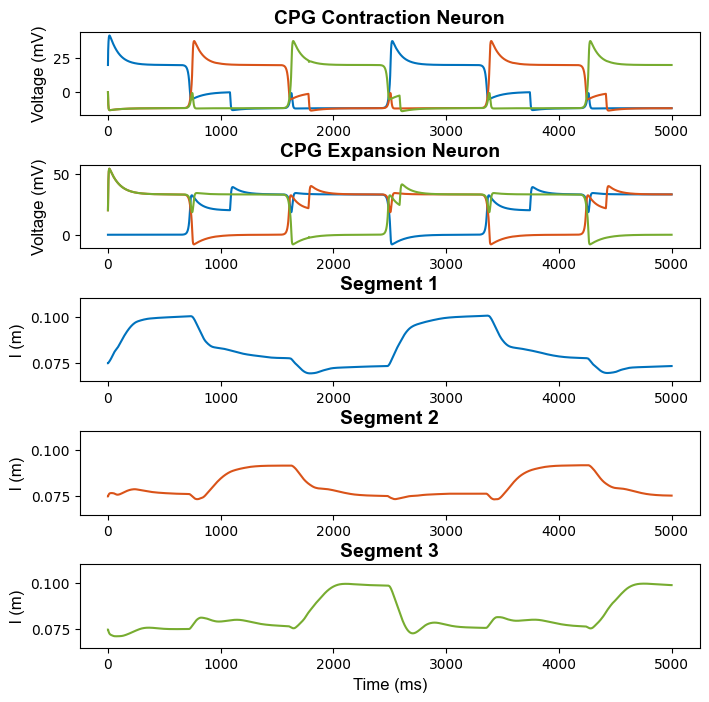

In [3]:
############################### Plotting ################################
# Plot 1: CPG U1 neuron potentials for each time step
# Plot 2: CPG U2 neuron potentials for each time step
# Plots 3-Nseg: Segemnt height or length over time (uncomment whichever is needed)

color_mat = np.array([[0, 0.4470, 0.7410], [0.8500, 0.3250, 0.0980], [0.4660, 0.6740, 0.1880], [0.4940, 0.1840, 0.5560]])

# color_mat = cm.rainbow(np.linspace(0, 1, Nseg))

fig = plt.figure()
Segment = "Segment "
for ct in range(1, Nseg+3):
    ax = fig.add_subplot(Nseg+2, 1, ct)
    if ct == 1:
        for j in range(Nseg):
            ax.plot(tSim, Usim1[:,j], color = color_mat[j,:])
        ax.set_ylabel('Voltage (mV)', fontsize = 12, fontname="Arial")
        ax.set_title('CPG Contraction Neuron', fontsize = 14, fontname="Arial", fontweight="bold")
    elif ct == 2:
        for j in range(Nseg):
            ax.plot(tSim, Usim2[:,j], color = color_mat[j,:])
        ax.set_ylabel('Voltage (mV)', fontsize = 12, fontname="Arial")
        ax.set_title('CPG Expansion Neuron', fontsize = 14, fontname="Arial", fontweight="bold")
    else:
        # ax.plot(tSim, h[:,ct-3], color = color_mat[ct-3,:])
        # ax.set_ylim(bottom = 0.10, top = 0.17)
        # ax.set_ylabel('w (m)')
        # ax.set_title(Segment + str(ct-2))

        ax.plot(tSim, l[:,ct-3], color = color_mat[ct-3,:])
        ax.set_ylim(bottom = 0.065, top = 0.11)
        ax.set_ylabel('l (m)', fontsize = 12, fontname="Arial")
        ax.set_title(Segment + str(ct-2), fontsize = 14, fontname="Arial", fontweight="bold")
plt.xlabel('Time (ms)', fontsize = 12, fontname="Arial")
fig.set_figheight(8)
fig.set_figwidth(8)
fig.subplots_adjust(hspace = 0.6)
# record max displacements for each segment
print(np.max(np.max(l[:,0]))-np.min(np.min(l[:,0])))
print(np.max(np.max(l[:,1]))-np.min(np.min(l[:,1])))
print(np.max(np.max(l[:,2]))-np.min(np.min(l[:,2])))
plt.show()

In [4]:
##### This section was used to plot data from the physical robot provided by Yifan Wang
# import numpy as np
# import math
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import cm
# # Extract physical worm robot stretch data provided by Wang et al.
# import pandas as pd

# robot_data = pd.read_excel('FullFSR.xlsx')

# L_l = "L_l "
# L_r = "L_r "
# t_robot = robot_data['t']
# t_robot = t_robot-t_robot[0]
# l_robot = np.zeros((np.size(t_robot), 8))
# # data given in mm, convert to m while reading in
# for i in range(4):
#     l_robot[:,2*i] = robot_data[L_l + str(i+1)]*1/1000
#     l_robot[:,2*i+1] = robot_data[L_r + str(i+1)]*1/1000

# # Plot the data (separated so not constantly reading in file)
# color_mat = np.array([[0, 0.4470, 0.7410], [0.8500, 0.3250, 0.0980], [0.4660, 0.6740, 0.1880], [0.4940, 0.1840, 0.5560]])
# # color_mat = cm.rainbow(np.linspace(0, 1, 4))
# fig = plt.figure()
# Segment = 'Segment '
# for i in range(4):
#     ax = fig.add_subplot(4, 1, i+1)
#     ax.plot(t_robot, l_robot[:,2*i], color = color_mat[i,:], label="left")
#     ax.plot(t_robot, l_robot[:,2*i+1], color = color_mat[i,:], linestyle='dashed', label="right")
#     ax.set_ylim(bottom = 0.05, top = 0.15)
#     ax.set_xlim(left = 0, right = np.max(t_robot))
#     ax.set_ylabel('l (m)', fontsize = 12, fontname="Arial")
#     ax.set_title(Segment + str(i+1), fontsize = 14, fontname="Arial", fontweight="bold")
#     if i == 0:
#         ax.legend(loc='upper right', fontsize = 9)
#     # else:
#     #     ax.legend(loc='upper left', fontsize = 8)
# plt.xlabel('Time (ms)', fontsize = 12, fontname="Arial")
# fig.set_figheight(7)
# fig.set_figwidth(8)
# fig.subplots_adjust(hspace = 0.55)

# # record max displacements for each segment
# L1_l_max = np.max(np.max(l_robot[:,0]))-np.min(np.min(l_robot[:,0]))
# L1_r_max = np.max(np.max(l_robot[:,1]))-np.min(np.min(l_robot[:,1]))
# print((L1_l_max+L1_r_max)/2)
# L2_l_max = np.max(np.max(l_robot[:,2]))-np.min(np.min(l_robot[:,2]))
# L2_r_max = np.max(np.max(l_robot[:,3]))-np.min(np.min(l_robot[:,3]))
# print((L2_l_max+L2_r_max)/2)
# L3_l_max = np.max(np.max(l_robot[:,4]))-np.min(np.min(l_robot[:,4]))
# L3_r_max = np.max(np.max(l_robot[:,5]))-np.min(np.min(l_robot[:,5]))
# print((L3_l_max+L3_r_max)/2)
# L4_l_max = np.max(np.max(l_robot[:,6]))-np.min(np.min(l_robot[:,6]))
# L4_r_max = np.max(np.max(l_robot[:,7]))-np.min(np.min(l_robot[:,7]))
# print((L4_l_max+L4_r_max)/2)
# plt.show()

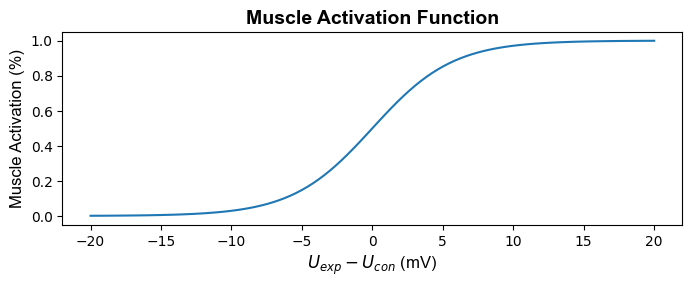

In [6]:
# Plot the sigmoid muscle activation function
dummy_x = np.linspace(-R,R,100)
dummy_y = sns2mujoco(dummy_x, -0.35, 0)

fig = plt.figure()
plt.plot(dummy_x,dummy_y)
plt.ylabel('Muscle Activation (%)', fontsize = 12, fontname="Arial")
plt.title('Muscle Activation Function', fontsize = 14, fontname="Arial", fontweight="bold")
plt.xlabel('$U_{exp}-U_{con}$ (mV)', fontsize = 12, fontname="Arial")
fig.set_figheight(2.5)
fig.set_figwidth(8)
plt.show()

2.4540049225527065


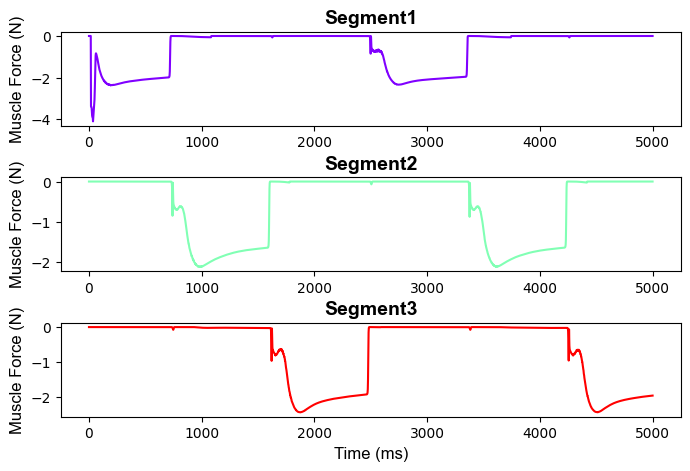

In [7]:
# Plot actuator force data
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(data_mj.actuator_force)
# # print(data_mj.qfrc_actuator)
# print(data_mj.qfrc_passive)

color_mat = cm.rainbow(np.linspace(0, 1, Nseg))

fig = plt.figure()
Segment = "Segment"
for ct in range(1, Nseg+1):
    ax = fig.add_subplot(Nseg, 1, ct)
    ax.plot(tSim, F_act[:,ct-1], color = color_mat[ct-1,:])
    # ax.set_ylim(bottom = 0.07, top = 0.11)
    ax.set_ylabel('Muscle Force (N)', fontsize = 12, fontname="Arial")
    ax.set_title(Segment + str(ct), fontsize = 14, fontname="Arial", fontweight="bold")
plt.xlabel('Time (ms)', fontsize = 12, fontname="Arial")
fig.set_figheight(5)
fig.set_figwidth(8)
fig.subplots_adjust(hspace = 0.55)
# record max force change actuators experience
print(np.max(np.max(F_act[100:,:]))-np.min(np.min(F_act[100:,:])))
plt.show()
# print(F_act[100:,:])